In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import os
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sns
import pandas as pd

In [2]:
# Data is stored in Google drive, accessed from Google collab
data_dir = '/content/drive/MyDrive/audio_data'
subdirs = ['test_data', 'train_data', 'validation_data']
subdirs_class = ['car', 'tram']
combined = [f"/{a}/{b}" for a in subdirs for b in subdirs_class]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !apt-get install ffmpeg

In [5]:
def convert_to_wav(dir):
  for file in os.listdir(dir):
     if file.endswith(('.mp3', '.flac', '.ogg', '.m4a')):
        input_path = os.path.join(dir, file)
        output_path = os.path.join(dir, os.path.splitext(file)[0] + '.wav')
        os.system(f'ffmpeg -i "{input_path}" "{output_path}"')
        os.remove(input_path)

def load_data(dir):
  audio_data = []
  for file in os.listdir(dir):
    data, fs = lb.load(os.path.join(dir, file), sr=None)
    normalized_data = data/np.max(np.abs(data))
    audio_data.append((normalized_data, fs))
  return audio_data

In [ ]:
# for elem in combined:
#   convert_to_wav(data_dir+elem)

In [6]:
car_train = load_data(data_dir + combined[2])
tram_train = load_data(data_dir + combined[3])

car_test = load_data(data_dir + combined[0])
tram_test = load_data(data_dir + combined[1])

car_validation = load_data(data_dir + combined[4])
tram_validation = load_data(data_dir + combined[5])

<ipython-input-5-2c59f339498f>:12: UserWarning: PySoundFile failed. Trying audioread instead.
  data, fs = lb.load(os.path.join(dir, file), sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-5-2c59f339498f>:12: UserWarning: PySoundFile failed. Trying audioread instead.
  data, fs = lb.load(os.path.join(dir, file), sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-5-2c59f339498f>:12: UserWarning: PySoundFile failed. Trying audioread instead.
  data, fs = lb.load(os.path.join(dir, file), sr=None)
/usr/local/lib/

In [7]:
def plot_spectrograms(spectrograms):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes = axes.flatten()

    for i, (S_db, sr) in enumerate(spectrograms):
        title = "Car Spectrogram" if i == 0 else "Tram Spectrogram"
        lb.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='viridis', ax=axes[i])
        axes[i].set_title(title)
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()


def plot_mfccs(mfccs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes = axes.flatten()

    for i, (mfcc, sr) in enumerate(mfccs):
        title = "Car MFCC" if i == 0 else "Tram MFCC"
        lb.display.specshow(mfcc, sr=sr, x_axis='time', cmap='viridis', ax=axes[i])
        axes[i].set_title(title)
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("MFCC Coefficients")

    plt.tight_layout()
    plt.show()


In [8]:
plot_signals = [car_train[1], tram_train[1]]
signal_spectrogram = []
signal_mfccs = []

for data, sr in plot_signals:
  signal_spectrogram.append((lb.amplitude_to_db(abs(lb.stft(data))), sr))
  signal_mfccs.append((lb.feature.mfcc(y=data, sr=sr, n_mfcc=13), sr))


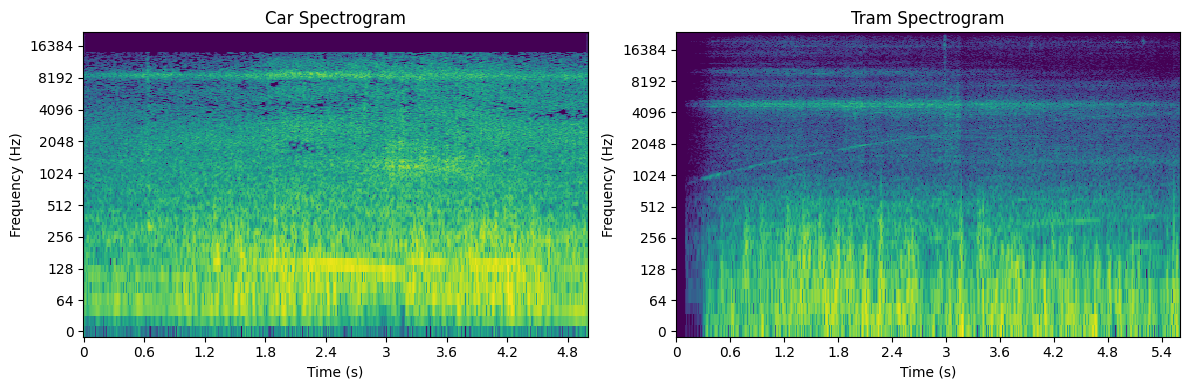

In [9]:
plot_spectrograms(signal_spectrogram)

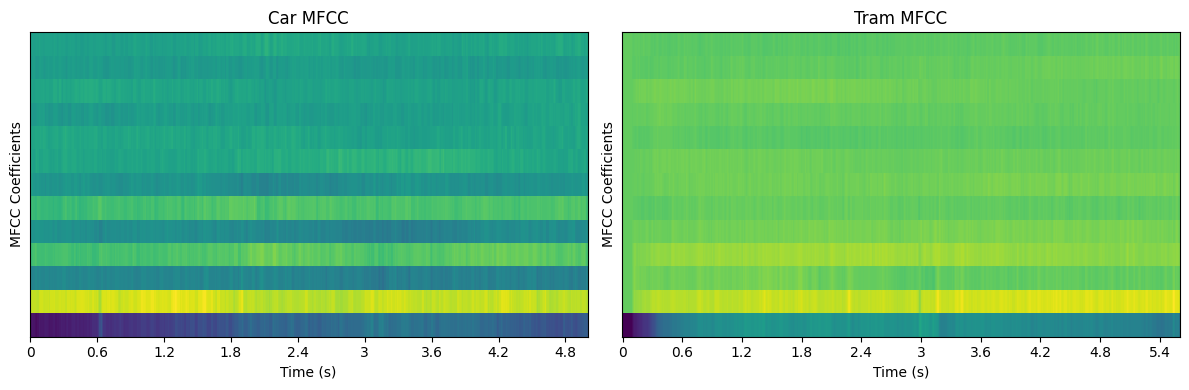

In [10]:
plot_mfccs(signal_mfccs)

Feature Analysis

In [11]:
def extract_zcr(signal):
    return np.mean(lb.feature.zero_crossing_rate(signal)[0])

def extract_rms(signal):
    return np.mean(lb.feature.rms(y=signal)[0])

def extract_spectral_centroid(signal, sr):
    return np.mean(lb.feature.spectral_centroid(y=signal, sr=sr)[0])

def extract_mfcc(signal, sr, n_mfcc=13):
    mfccs = lb.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)

def extract_single_feature(audio_data, feature_type):
    features = []
    for signal, sr in audio_data:
        if feature_type == "zcr":
            feature = np.array([extract_zcr(signal)])
        elif feature_type == "rms":
            feature = np.array([extract_rms(signal)])
        elif feature_type == "spectral_centroid":
            feature = np.array([extract_spectral_centroid(signal, sr)])
        elif feature_type == "mfcc":
            feature = extract_mfcc(signal, sr)
        features.append(feature)
    return np.array(features)

In [12]:
features_to_test = ["zcr", "rms", "spectral_centroid", "mfcc"]

results = {}
for feature in features_to_test:
    X_train = extract_single_feature(car_train + tram_train, feature)
    y_train = np.array(["car"] * len(car_train) + ["tram"] * len(tram_train))

    X_validation = extract_single_feature(car_validation + tram_validation, feature)
    y_validation = np.array(["car"] * len(car_validation) + ["tram"] * len(tram_validation))

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    lg_model = LogisticRegression()
    lg_model.fit(X_train_scaled, y_train)

    y_pred = lg_model.predict(X_validation_scaled)

    accuracy = metrics.accuracy_score(y_validation, y_pred)
    precision = metrics.precision_score(y_validation, y_pred, pos_label="car")
    recall = metrics.recall_score(y_validation, y_pred, pos_label="car")
    f1 = metrics.f1_score(y_validation, y_pred, pos_label="car")

    results[feature] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

    print(f"Feature: {feature}")
    print(classification_report(y_validation, y_pred, target_names=["car", "tram"]))

Feature: zcr
              precision    recall  f1-score   support

         car       0.60      0.24      0.35        49
        tram       0.54      0.85      0.66        52

    accuracy                           0.55       101
   macro avg       0.57      0.55      0.50       101
weighted avg       0.57      0.55      0.51       101

Feature: rms
              precision    recall  f1-score   support

         car       0.59      0.67      0.63        49
        tram       0.64      0.56      0.60        52

    accuracy                           0.61       101
   macro avg       0.62      0.62      0.61       101
weighted avg       0.62      0.61      0.61       101

Feature: spectral_centroid
              precision    recall  f1-score   support

         car       0.50      0.41      0.45        49
        tram       0.52      0.62      0.57        52

    accuracy                           0.51       101
   macro avg       0.51      0.51      0.51       101
weighted avg       0.

In [13]:
print(pd.DataFrame(results).T)

                   Accuracy  Precision    Recall  F1-Score
zcr                0.554455   0.600000  0.244898  0.347826
rms                0.613861   0.589286  0.673469  0.628571
spectral_centroid  0.514851   0.500000  0.408163  0.449438
mfcc               0.910891   0.857143  0.979592  0.914286


In [14]:
best_feature = max(results, key=lambda feature: results[feature]["Accuracy"])
print(f"Best feature based on validation data: {best_feature}")

Best feature based on validation data: mfcc


Testing

In [15]:
X_full_train = extract_single_feature(car_train + car_validation + tram_train + tram_validation, 'mfcc')
y_full_train = np.array(["car"] * (len(car_train) + len(car_validation)) + ["tram"] * (len(tram_train) + len(tram_validation)))

X_full_train_scaled = scaler.fit_transform(X_full_train)

In [16]:
lg_model = LogisticRegression()
lg_model.fit(X_full_train_scaled, y_full_train)

LogisticRegression()

In [17]:
X_test = extract_single_feature(car_test + tram_test, 'mfcc')
y_test = np.array(["car"] * len(car_test) + ["tram"] * len(tram_test))

X_test_scaled = scaler.transform(X_test)

              precision    recall  f1-score   support

         car       1.00      1.00      1.00        29
        tram       1.00      1.00      1.00        24

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53



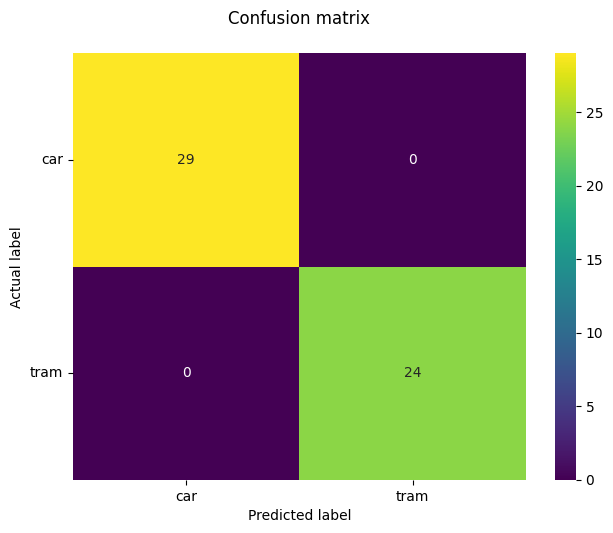

In [18]:
test_pred = lg_model.predict(X_test_scaled)
cnf_matrix_test = metrics.confusion_matrix(y_test, test_pred)

class_names = ["car", "tram"]
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix_test), annot=True, fmt="g", xticklabels=class_names, yticklabels=class_names, cmap="viridis")
plt.yticks(rotation=0)
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title("Confusion matrix", y=1.05)
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

target_names = ["car", "tram"]
print(classification_report(y_test, test_pred, target_names=target_names))

Model weights

<ipython-input-19-5a9f096c2ac6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_names, y=coefficents, palette="viridis")


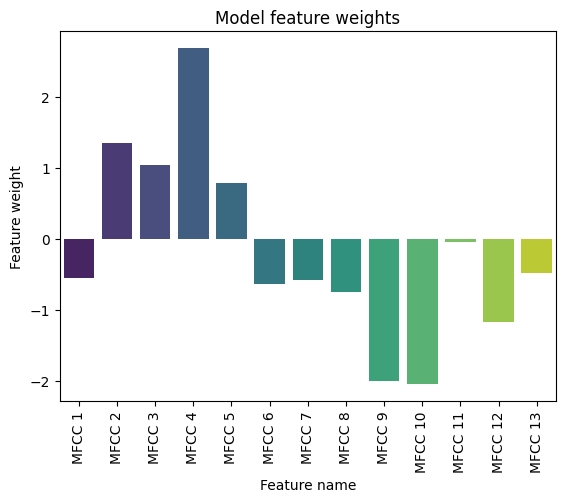

In [19]:
coefficents = lg_model.coef_[0]

feature_names = [f"MFCC {i}" for i in range(1, len(coefficents) + 1)]

sns.barplot(x=feature_names, y=coefficents, palette="viridis")
plt.xticks(rotation=90)
plt.title("Model feature weights")
plt.xlabel("Feature name")
plt.ylabel("Feature weight")
plt.show()

Model bias

In [20]:
lg_model.intercept_

array([0.43257543])

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lg_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.94684385 0.95348837 0.95016611 0.95016611 0.90365449]
Mean cross-validation score: 0.9408637873754152
